In [2]:
# --- Repo + path setup ---

import os, sys

# 1) Clone repo if it doesn't exist
if not os.path.exists('/content/bdh_challenge_2025'):
    %cd /content
    !git clone https://github.com/arionandrei2000/bdh_challenge_2025.git

# 2) Move into repo root
%cd /content/bdh_challenge_2025
print("PWD:", os.getcwd())
print("Repo contents:", os.listdir())

# 3) src is under notebooks/src, so add that parent folder to sys.path
src_parent = "/content/bdh_challenge_2025/notebooks"
if src_parent not in sys.path:
    sys.path.append(src_parent)

print("sys.path updated; ready to import src.")


/content
Cloning into 'bdh_challenge_2025'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 101 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 40.98 KiB | 5.12 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/bdh_challenge_2025
PWD: /content/bdh_challenge_2025
Repo contents: ['README.md', '.git', 'notebooks']
sys.path updated; ready to import src.


In [ ]:
# 01) Dependencies

# Core Python packages used in this notebook
# - pandas / numpy: data manipulation
# - pyarrow: for saving Parquet
# - requests: HTTP requests to GDC API
# - tqdm: progress bars
!pip install pandas numpy pyarrow requests tqdm pyranges --quiet

# Download GDC client
!wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip -O gdc.zip -q
!unzip -o gdc.zip > /dev/null
!chmod +x gdc-client

print("Installed Python deps and downloaded gdc-client.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... canceledERROR: Operation cancelled by user
^C


KeyboardInterrupt: 

In [3]:

# 02) Mount GDrive
# This lets us store large TCGA data in Drive so it persists across sessions

from google.colab import drive
drive.mount('/content/drive')

print(" Google Drive mounted at /content/drive")


Mounted at /content/drive
 Google Drive mounted at /content/drive


In [4]:
# 03) Project Paths in Google Drive

from pathlib import Path
import os

# Main project root on Google Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROJECT_ROOT.mkdir(exist_ok=True)

# Data directories

# Generic data directory
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# Directory where raw TCGA STAR count files will be stored
RNA_DIR = PROJECT_ROOT / "tcga_rna"
RNA_DIR.mkdir(exist_ok=True)

# Directory where processed matrices, tokenized data, embeddings
PROCESSED_DIR = PROJECT_ROOT / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

print("Project root :", PROJECT_ROOT)
print("DATA_DIR     :", DATA_DIR)
print("RNA_DIR      :", RNA_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)




Project root : /content/drive/MyDrive/bdh_challenge_2025_data
DATA_DIR     : /content/drive/MyDrive/bdh_challenge_2025_data/data
RNA_DIR      : /content/drive/MyDrive/bdh_challenge_2025_data/tcga_rna
PROCESSED_DIR: /content/drive/MyDrive/bdh_challenge_2025_data/processed


In [5]:
# 04) Imports and TCGA cohort

import os
import json
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm

# We explicitly list the TCGA projects we will include. THIS CAN BE CHANGED!

BULK_RNABERT_PROJECTS = [
    "TCGA-BRCA",  # Breast invasive carcinoma
    "TCGA-BLCA",  # Bladder urothelial carcinoma
    "TCGA-GBM",   # Glioblastoma multiforme
    "TCGA-LGG",   # Lower grade glioma
    "TCGA-LUAD",  # Lung adenocarcinoma
    "TCGA-UCEC",  # Uterine corpus endometrial carcinoma
]

print("Cohorts for this run:")
for p in BULK_RNABERT_PROJECTS:
    print(" -", p)


Cohorts for this run:
 - TCGA-BRCA
 - TCGA-BLCA
 - TCGA-GBM
 - TCGA-LGG
 - TCGA-LUAD
 - TCGA-UCEC


In [ ]:

# 05) QUERY GDC FOR GENE EXPRESSION (STAR - COUNTS)

# We ask GDC:
#  - data_category: Transcriptome Profiling
#  - data_type: Gene Expression Quantification
#  - projects: the 6 TCGA projects above


files_query = {
    "filters": {
        "op": "and",
        "content": [
            {
                "op": "in",
                "content": {
                    "field": "cases.project.project_id",
                    "value": BULK_RNABERT_PROJECTS,
                },
            },
            {
                "op": "in",
                "content": {
                    "field": "data_category",
                    "value": ["Transcriptome Profiling"],
                },
            },
            {
                "op": "in",
                "content": {
                    "field": "data_type",
                    "value": ["Gene Expression Quantification"],
                },
            },
        ],
    },
    "format": "JSON",
    "size": 20000,
    "fields": (
        "file_id,file_name,"
        "cases.submitter_id,cases.project.project_id,"
        "data_category,data_type,analysis.workflow_type"
    ),
}

resp = requests.post(
    "https://api.gdc.cancer.gov/files",
    headers={"Content-Type": "application/json"},
    data=json.dumps(files_query),
)

resp_json = resp.json()
files_json = resp_json.get("data", {}).get("hits", [])

print("HTTP status:", resp.status_code)
print("Number of files for selected projects:", len(files_json))

if len(files_json) == 0:
    print(" GDC returned 0 files. Pagination/debug:")
    print(json.dumps(resp_json.get("data", {}).get("pagination", {}), indent=2))
    raise RuntimeError("GDC returned 0 files for this query. Adjust filters or check connection.")

# Convert JSON list to DataFrame
files_df = pd.json_normalize(files_json)

def _get_first_case(x):
    """Helper: for 'cases' field that is a list, return the first dict or {}."""
    if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict):
        return x[0]
    return {}

# Extract submitter_id and project_id from nested 'cases' field
files_df["submitter_id"] = files_df["cases"].apply(
    lambda x: _get_first_case(x).get("submitter_id", None)
)
files_df["project_id"] = files_df["cases"].apply(
    lambda x: _get_first_case(x).get("project_id", None)
)

print("Unique workflows in these files:")
print(files_df["analysis.workflow_type"].value_counts())

files_df[
    ["file_id", "file_name", "submitter_id", "project_id",
     "data_category", "data_type", "analysis.workflow_type"]
].head()


HTTP status: 200
Number of files for selected projects: 3777
Unique workflows in these files:
analysis.workflow_type
STAR - Counts    3777
Name: count, dtype: int64


,file_id,file_name,submitter_id,project_id,data_category,data_type,analysis.workflow_type
0,9dc09c86-c728-4bd9-b2b6-2d9962dad662,d1f1743c-5fd9-4ae8-90c2-8c3e2d475d1b.rna_seq.a...,TCGA-EW-A2FS,None,Transcriptome Profiling,Gene Expression Quantification,STAR - Counts
1,95668f0b-130d-44d4-94c0-ba7a4e7798e6,6365a756-2e65-42cb-be4f-1f726915ca94.rna_seq.a...,TCGA-OL-A6VR,None,Transcriptome Profiling,Gene Expression Quantification,STAR - Counts
2,461fda5d-d6e6-4354-b035-c302cc43b03f,30285113-d411-475a-a8ed-1fb66be72f28.rna_seq.a...,TCGA-E9-A226,None,Transcriptome Profiling,Gene Expression Quantification,STAR - Counts
3,30ff778c-844b-4140-9025-7ab1938f10a9,5167da8c-2b1c-4139-a2c4-355e9f07d0be.rna_seq.a...,TCGA-A8-A08H,None,Transcriptome Profiling,Gene Expression Quantification,STAR - Counts
4,427a04c9-9b48-49de-8a47-2adc4e1dd32a,fead73ce-2e66-4647-8b6c-b8bbdaaf30fe.rna_seq.a...,TCGA-D8-A27H,None,Transcriptome Profiling,Gene Expression Quantification,STAR - Counts


In [ ]:
# 06) Create MANIFEST & DOWNLOAD star counts TO GDrive

# GDC client expects a manifest file with an "id" column listing file_ids.

manifest = files_df[["file_id"]].rename(columns={"file_id": "id"})
manifest_path = PROJECT_ROOT / "manifest_star_counts.txt"
manifest.to_csv(manifest_path, sep="\t", index=False)

print("Manifest written to:", manifest_path)
print("Total files listed:", manifest.shape[0])

# Download all files into RNA_DIR (in Google Drive).
# gdc-client will skip files that are already complete.
!./gdc-client download -m {manifest_path} -d {RNA_DIR}

print(" Download finished (check tcga_rna/ in Google Drive).")


Manifest written to: /content/drive/MyDrive/bdh_challenge_2025_data/manifest_star_counts.txt
Total files listed: 3777
/bin/bash: line 1: ./gdc-client: No such file or directory
 Download finished (check tcga_rna/ in Google Drive).


In [ ]:
# 07) Getting the STAR counts matrix
#
# This version:
#  - Only processes STAR gene count files (augmented_star_gene_counts.tsv)
#  - Reads with header row
#  - Drops N_* and __* summary rows
#  - Works with partial downloads
#  - Stores counts as float32 (half the RAM vs float64)

id_to_sample = dict(zip(files_df["file_id"], files_df["submitter_id"]))
print("Number of file_id → sample mappings:", len(id_to_sample))

all_files = []
for root, dirs, files in os.walk(RNA_DIR):
    for f in files:
        # STAR gene count files usually contain 'rna_seq' and 'gene_counts'
        if f.endswith(".tsv") and "rna_seq" in f and "gene_counts" in f:
            all_files.append(os.path.join(root, f))

print("Number of STAR gene count files on disk:", len(all_files))

MAX_FILES = None
if MAX_FILES is not None:
    all_files = all_files[:MAX_FILES]
    print(f"Using only first {len(all_files)} files.")

gene_index = None
matrix = {}
skipped = []

for fpath in tqdm(all_files):
    fname = os.path.basename(fpath)

    # Folder name created by gdc-client is the file_id
    file_id = os.path.basename(os.path.dirname(fpath))
    sample = id_to_sample.get(file_id)
    if sample is None:
        skipped.append((fname, "no sample mapping"))
        continue

    # Read gene counts table; ignore comment lines starting with '#'
    df = pd.read_csv(fpath, sep="\t", comment="#")

    # Identify gene ID column
    if "gene_id" in df.columns:
        gene_col = "gene_id"
    elif "Geneid" in df.columns:
        gene_col = "Geneid"
    else:
        skipped.append((fname, f"no gene_id column, cols = {df.columns.tolist()}"))
        continue

    # Identify counts column
    if "unstranded" in df.columns:
        counts_col = "unstranded"
    else:
        # pick the first non-gene_id/gene_name column as fallback
        candidate_cols = [c for c in df.columns if c not in [gene_col, "gene_name"]]
        if not candidate_cols:
            skipped.append((fname, "no suitable count column"))
            continue
        counts_col = candidate_cols[0]

    # Drop technical summary rows: N_unmapped, N_multimapping, __no_feature, etc.
    df = df[~df[gene_col].astype(str).str.startswith("N_")]
    df = df[~df[gene_col].astype(str).str.startswith("__")]
    df = df.reset_index(drop=True)

    # Initialize or check gene ordering
    if gene_index is None:
        gene_index = df[gene_col].values
    else:
        if not np.array_equal(gene_index, df[gene_col].values):
            raise ValueError(f"Gene order mismatch in file: {fpath}")

    # Extract counts as float32 (saves RAM vs float64)
    counts = pd.to_numeric(df[counts_col], errors="raise").astype("float32").values
    matrix[sample] = counts

# Build counts matrix (genes x samples) and store as float32
expr_counts = pd.DataFrame(matrix, index=gene_index).astype("float32")

print("Counts matrix shape (genes x samples):", expr_counts.shape)
display(expr_counts.iloc[:5, :5])

print("Skipped files:", len(skipped))
if skipped:
    print(skipped[:5])


Number of file_id → sample mappings: 3777
Number of STAR gene count files on disk: 3777


100%|██████████| 3777/3777 [52:40<00:00,  1.20it/s]


Counts matrix shape (genes x samples): (60660, 3385)


,TCGA-P5-A5EY,TCGA-AR-A1AW,TCGA-E9-A1N5,TCGA-97-7941,TCGA-93-7347
ENSG00000000003.15,2377.0,2273.0,2036.0,11528.0,1381.0
ENSG00000000005.6,8.0,13.0,39.0,13.0,5.0
ENSG00000000419.13,649.0,2077.0,703.0,1547.0,998.0
ENSG00000000457.14,331.0,1459.0,764.0,1257.0,715.0
ENSG00000000460.17,79.0,726.0,251.0,232.0,195.0


Skipped files: 0


In [ ]:
# 08) Doing TPM-like normalization on Counts
# We approximatd TPM by:
#   TPM_like = (counts / sum(counts)) * 1e6 per sample.
# This keeps per-sample library size comparable across samples.

# Very close to using FPKM→TPM for a lot of downstream modeling use cases. LET'S double check this! Why?

def counts_to_tpm_like(column: pd.Series) -> pd.Series:
    total = column.sum()
    if total == 0:
        return column
    return (column / total) * 1e6

expr_tpm = expr_counts.apply(counts_to_tpm_like, axis=0)
print("TPM-like matrix shape (genes x samples):", expr_tpm.shape)
expr_tpm.iloc[:5, :5]


TPM-like matrix shape (genes x samples): (60660, 3385)


,TCGA-P5-A5EY,TCGA-AR-A1AW,TCGA-E9-A1N5,TCGA-97-7941,TCGA-93-7347
ENSG00000000003.15,47.031635,39.358894,69.550377,178.855652,23.861710
ENSG00000000005.6,0.158289,0.225106,1.332252,0.201694,0.086393
ENSG00000000419.13,12.841199,35.964989,24.014692,24.001535,17.244017
ENSG00000000457.14,6.549210,25.263803,26.098471,19.502218,12.354180
ENSG00000000460.17,1.563104,12.571296,8.574236,3.599455,3.369322


In [ ]:
# 09) Clean genes, reorient to samples x genes, log-transform, and save
#
# Starting point:
#   - expr_counts : (genes x samples), float32
#   - expr_tpm    : (genes x samples), TPM-like
#
# This cell:
#   (1) Strips Ensembl version suffixes (ENSG...15 -> ENSG...)
#   (2) Removes duplicates in BOTH matrices
#   (3) Intersects gene sets so counts & TPM have identical genes
#   (4) Reorients to (samples x genes)
#   (5) Applies log10(1 + TPM-like)
#   (6) Saves outputs

import gc
import numpy as np
import os

# 1) Strip Ensembl version suffix from gene IDs
expr_tpm.index    = expr_tpm.index.to_series().str.split(".").str[0]
expr_counts.index = expr_counts.index.to_series().str.split(".").str[0]


# 2) Remove duplicate genes IN BOTH MATRICES
expr_tpm    = expr_tpm[~expr_tpm.index.duplicated(keep="first")]
expr_counts = expr_counts[~expr_counts.index.duplicated(keep="first")]

# 3) Intersect genes so both matrices have identical gene sets
common_genes = expr_tpm.index.intersection(expr_counts.index)
expr_tpm    = expr_tpm.loc[common_genes].sort_index()
expr_counts = expr_counts.loc[common_genes].sort_index()

print("After strip + dedupe + intersect:")
print("  expr_counts shape:", expr_counts.shape)
print("  expr_tpm    shape:", expr_tpm.shape)

# 4) Reorient to (samples x genes)
expr_counts_sxg = expr_counts.T.astype("float32").copy()
expr_tpm_sxg    = expr_tpm.T.astype("float32").copy()

expr_counts_sxg.index.name = "sample_id"
expr_tpm_sxg.index.name    = "sample_id"

print("Counts   (samples x genes):", expr_counts_sxg.shape)
print("TPM-like (samples x genes):", expr_tpm_sxg.shape)

gc.collect()

# 5) Log-transform: log10(1 + TPM-like)
expr_tpm_log = np.log10(1.0 + expr_tpm_sxg.astype("float32"))
print("Log10(1 + TPM-like) shape:", expr_tpm_log.shape)

# 6) Save matrices to disk (into Google Drive)
from pathlib import Path

# Use the PROCESSED_DIR defined in the paths cell
OUT_DIR = PROCESSED_DIR  # this is a Path object pointing to .../bdh_challenge_2025_data/processed
OUT_DIR.mkdir(parents=True, exist_ok=True)

expr_counts_sxg.to_parquet(OUT_DIR / "tcga_star_counts_sxg.parquet")
expr_tpm_sxg.to_parquet(OUT_DIR / "tcga_tpm_like_sxg.parquet")
expr_tpm_log.to_parquet(OUT_DIR / "tcga_tpm_like_log10_sxg.parquet")

print("Saved processed matrices to:", OUT_DIR)

# Optional: verify files
print("Processed directory contents:")
for p in OUT_DIR.iterdir():
    print("  -", p.name)


After strip + dedupe + intersect:
  expr_counts shape: (60616, 3385)
  expr_tpm    shape: (60616, 3385)
Counts   (samples x genes): (3385, 60616)
TPM-like (samples x genes): (3385, 60616)
Log10(1 + TPM-like) shape: (3385, 60616)
Saved processed matrices to: /content/drive/MyDrive/bdh_challenge_2025_data/processed
Processed directory contents:
  - tcga_star_counts_sxg.parquet
  - tcga_tpm_like_sxg.parquet
  - tcga_tpm_like_log10_sxg.parquet


In [ ]:
# 10) Align our TCGA log-TPM matrix to BulkRNABert gene list (common_gene_id.txt)

import pandas as pd
import numpy as np
from pathlib import Path

GENE_LIST_PATH = DATA_DIR / "common_gene_id.txt"
TPM_LOG_PATH   = PROCESSED_DIR / "tcga_tpm_like_log10_sxg.parquet"

print("Gene list path:", GENE_LIST_PATH)
print("Log TPM matrix path:", TPM_LOG_PATH)

# 1) Load authors' gene list
# File is one gene ID per line
with open(GENE_LIST_PATH) as f:
    author_genes = [line.strip() for line in f if line.strip()]

author_genes = pd.Index(author_genes, name="gene_id")
print("Genes in authors' list:", len(author_genes))
print(author_genes[:5])

# 2) Load our processed log TPM matrix (samples x genes)
expr_tpm_log = pd.read_parquet(TPM_LOG_PATH)
print("Our TCGA log-TPM matrix shape (samples x genes):", expr_tpm_log.shape)

# Make sure columns are strings (gene IDs)
expr_tpm_log.columns = expr_tpm_log.columns.astype(str)

# 3) Check overlaps between our genes and authors' genes
our_genes = pd.Index(expr_tpm_log.columns, name="gene_id")
common = author_genes.intersection(our_genes)
missing_in_ours = author_genes.difference(our_genes)
extra_in_ours = our_genes.difference(author_genes)

print("\n=== Gene set diagnostics ===")
print("Genes in our matrix        :", len(our_genes))
print("Genes in authors' list     :", len(author_genes))
print("Common genes               :", len(common))
print("Authors' genes missing in ours:", len(missing_in_ours))
print("Our genes not in authors' list:", len(extra_in_ours))

if len(common) == 0:
    raise ValueError("No overlap between TCGA genes and author gene list – check ID format!")

print("\nExample authors' genes missing in our matrix:", list(missing_in_ours[:10]))

# 4) Reindex to authors' order (BulkRNABert canonical order)
# This will create columns for ALL author_genes, preserving order.
# Genes that we don't have will be NaN.
expr_aligned = expr_tpm_log.reindex(columns=author_genes)

print("\nAligned matrix shape (samples x authors' genes):", expr_aligned.shape)

# 5) Handle missing values & basic sanity checks
nan_count = expr_aligned.isna().sum().sum()
print("Total NaN values in aligned matrix:", nan_count)

# Strategy: fill missing genes with 0.0 (log10(1+TPM)=0 => TPM=0)
expr_aligned = expr_aligned.fillna(0.0).astype("float32")

# Quick distribution check
print("\nAligned matrix summary (first 5 genes):")
print(expr_aligned.iloc[:, :5].describe().T)

# 6) Save aligned matrix
ALIGNED_PATH = PROCESSED_DIR / "tcga_tpm_like_log10_bulkrnabert_aligned.parquet"
expr_aligned.to_parquet(ALIGNED_PATH)

print("\nSaved aligned matrix to:", ALIGNED_PATH)


Gene list path: /content/drive/MyDrive/bdh_challenge_2025_data/data/common_gene_id.txt
Log TPM matrix path: /content/drive/MyDrive/bdh_challenge_2025_data/processed/tcga_tpm_like_log10_sxg.parquet
Genes in authors' list: 19062
Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460'],
      dtype='object', name='gene_id')
Our TCGA log-TPM matrix shape (samples x genes): (3385, 60616)

=== Gene set diagnostics ===
Genes in our matrix        : 60616
Genes in authors' list     : 19062
Common genes               : 19062
Authors' genes missing in ours: 0
Our genes not in authors' list: 41554

Example authors' genes missing in our matrix: []

Aligned matrix shape (samples x authors' genes): (3385, 19062)
Total NaN values in aligned matrix: 0

Aligned matrix summary (first 5 genes):
                  count      mean       std       min       25%       50%  \
gene_id                                                                     
ENSG0000

In [33]:
import json, requests
import pandas as pd
from tqdm import tqdm

print("Projects:", BULK_RNABERT_PROJECTS)

cases_query = {
    "filters": {
        "op": "in",
        "content": {
            "field": "project.project_id",
            "value": BULK_RNABERT_PROJECTS,
        },
    },
    "format": "JSON",
    "size": 10000,
    "fields": ",".join([
        "case_id",
        "submitter_id",
        "project.project_id",
        # --- key survival fields: use DEMOGRAPHIC ---
        "demographic.vital_status",
        "demographic.days_to_death",
        "demographic.days_to_last_follow_up",
        # demographics extras
        "demographic.gender",
        "demographic.race",
        "demographic.ethnicity",
        # diagnoses: keep for descriptive stuff / backup
        "diagnoses.age_at_diagnosis",
        "diagnoses.tumor_stage",
        "diagnoses.primary_diagnosis",
        "diagnoses.morphology",
        "diagnoses.days_to_death",
        "diagnoses.days_to_last_follow_up",
        "diagnoses.days_to_last_known_alive",
    ]),
}

resp = requests.post(
    "https://api.gdc.cancer.gov/cases",
    headers={"Content-Type": "application/json"},
    data=json.dumps(cases_query),
)

print("HTTP status:", resp.status_code)
cases_json = resp.json()
cases_hits = cases_json.get("data", {}).get("hits", [])
print("Number of case records returned:", len(cases_hits))

if len(cases_hits) == 0:
    raise RuntimeError("No clinical cases returned from GDC. Check query or network.")


Projects: ['TCGA-BRCA', 'TCGA-BLCA', 'TCGA-GBM', 'TCGA-LGG', 'TCGA-LUAD', 'TCGA-UCEC']
HTTP status: 200
Number of case records returned: 3788


In [35]:
import numpy as np

def _safe_get(d, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(k, default)
        else:
            return default
    return cur if cur is not None else default

rows = []
for c in tqdm(cases_hits, desc="Building clinical rows (demographic-based survival)"):
    submitter = c.get("submitter_id")
    if submitter is None:
        continue

    project_id = _safe_get(c, "project", "project_id")
    cohort = project_id.replace("TCGA-", "") if project_id is not None else None

    demo = c.get("demographic") or {}
    diags = c.get("diagnoses") or []

    gender = demo.get("gender")
    race = demo.get("race")
    ethnicity = demo.get("ethnicity")
    vital_status = demo.get("vital_status")

    # --- primary survival info from DEMOGRAPHIC ---
    demo_death = demo.get("days_to_death")
    demo_follow = demo.get("days_to_last_follow_up")

    # --- backup from DIAGNOSES (may be mostly empty, but doesn’t hurt) ---
    diag_deaths = []
    diag_follows = []
    for d in diags:
        if d.get("days_to_death") is not None:
            diag_deaths.append(d.get("days_to_death"))
        # last_follow_up / last_known_alive
        dlfu = d.get("days_to_last_follow_up")
        dlka = d.get("days_to_last_known_alive")
        follow = dlfu if dlfu is not None else dlka
        if follow is not None:
            diag_follows.append(follow)

    death_times = []
    follow_times = []

    if demo_death is not None:
        death_times.append(demo_death)
    death_times.extend(diag_deaths)

    if demo_follow is not None:
        follow_times.append(demo_follow)
    follow_times.extend(diag_follows)

    death_time = max(death_times) if len(death_times) > 0 else None
    follow_time = max(follow_times) if len(follow_times) > 0 else None

    # --- survival_time / event ---
    survival_time = None
    event = None

    if death_time is not None:
        survival_time = float(death_time)
        event = 1.0
    elif follow_time is not None:
        survival_time = float(follow_time)
        event = 0.0

    # fix negative times (set to NaN; we’ll drop them later)
    if survival_time is not None and survival_time < 0:
        survival_time = np.nan
        event = np.nan

    # For descriptive stuff, just take first diagnosis if present
    primary = diags[0] if diags else {}
    age_at_diag = primary.get("age_at_diagnosis")
    tumor_stage = primary.get("tumor_stage")
    primary_dx = primary.get("primary_diagnosis")
    morphology = primary.get("morphology")

    row = {
        "sample_id": submitter,
        "project_id": project_id,
        "cohort": cohort,
        "gender": gender,
        "race": race,
        "ethnicity": ethnicity,
        "vital_status": vital_status,
        "age_at_diagnosis": age_at_diag,
        "tumor_stage": tumor_stage,
        "primary_diagnosis": primary_dx,
        "morphology": morphology,
        "survival_time": survival_time,
        "event": event,
    }
    rows.append(row)

clinical_df = pd.DataFrame(rows)
print("Clinical table shape:", clinical_df.shape)
clinical_df.head(100)


Building clinical rows (demographic-based survival): 100%|██████████| 3788/3788 [00:00<00:00, 176161.70it/s]

Clinical table shape: (3788, 13)


,sample_id,project_id,cohort,gender,race,ethnicity,vital_status,age_at_diagnosis,tumor_stage,primary_diagnosis,morphology,survival_time,event
0,TCGA-E2-A107,TCGA-BRCA,BRCA,female,white,not hispanic or latino,Alive,20065.0,None,"Lobular carcinoma, NOS",8520/3,1047.0,0.0
1,TCGA-AC-A62X,TCGA-BRCA,BRCA,female,black or african american,not hispanic or latino,Alive,26627.0,None,"Infiltrating duct carcinoma, NOS",8500/3,417.0,0.0
2,TCGA-E2-A156,TCGA-BRCA,BRCA,female,white,not hispanic or latino,Alive,22422.0,None,"Infiltrating duct carcinoma, NOS",8500/3,726.0,0.0
3,TCGA-A7-A56D,TCGA-BRCA,BRCA,female,black or african american,not hispanic or latino,Alive,30783.0,None,"Infiltrating duct carcinoma, NOS",8500/3,448.0,0.0
4,TCGA-AR-A0U1,TCGA-BRCA,BRCA,female,white,not hispanic or latino,Alive,13467.0,None,"Infiltrating duct carcinoma, NOS",8500/3,4052.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,TCGA-E2-A576,TCGA-BRCA,BRCA,female,black or african american,not hispanic or latino,Alive,25350.0,None,"Lobular carcinoma, NOS",8520/3,1043.0,0.0
96,TCGA-A8-A083,TCGA-BRCA,BRCA,female,not reported,not reported,Alive,24746.0,None,"Infiltrating duct carcinoma, NOS",8500/3,0.0,0.0
97,TCGA-A1-A0SK,TCGA-BRCA,BRCA,female,asian,not hispanic or latino,Dead,20048.0,None,Large cell neuroendocrine carcinoma,8013/3,967.0,1.0
98,TCGA-E9-A1ND,TCGA-BRCA,BRCA,female,white,not hispanic or latino,Alive,27400.0,None,"Infiltrating duct carcinoma, NOS",8500/3,1266.0,0.0


from matplotlib import pyplot as plt
_df_104['age_at_diagnosis'].plot(kind='hist', bins=20, title='age_at_diagnosis')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_105['survival_time'].plot(kind='hist', bins=20, title='survival_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_106['event'].plot(kind='hist', bins=20, title='event')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_107.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_108.groupby('race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_109.groupby('ethnicity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_110.groupby('vital_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_111.plot(kind='scatter', x='age_at_diagnosis', y='survival_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_112.plot(kind='scatter', x='survival_time', y='event', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['survival_time']
  ys = series['age_at_diagnosis']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_113.sort_values('survival_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('survival_time')
_ = plt.ylabel('age_at_diagnosis')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['survival_time']
  ys = series['age_at_diagnosis']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_114.sort_values('survival_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('race')):
  _plot_series(series, series_name, i)
  fig.legend(title='race', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('survival_time')
_ = plt.ylabel('age_at_diagnosis')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['survival_time']
  ys = series['age_at_diagnosis']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_115.sort_values('survival_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ethnicity')):
  _plot_series(series, series_name, i)
  fig.legend(title='ethnicity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('survival_time')
_ = plt.ylabel('age_at_diagnosis')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['survival_time']
  ys = series['age_at_diagnosis']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_116.sort_values('survival_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('vital_status')):
  _plot_series(series, series_name, i)
  fig.legend(title='vital_status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('survival_time')
_ = plt.ylabel('age_at_diagnosis')

from matplotlib import pyplot as plt
_df_117['age_at_diagnosis'].plot(kind='line', figsize=(8, 4), title='age_at_diagnosis')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_118['survival_time'].plot(kind='line', figsize=(8, 4), title='survival_time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_119['event'].plot(kind='line', figsize=(8, 4), title='event')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race'].value_counts()
    for x_label, grp in _df_120.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('race')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['ethnicity'].value_counts()
    for x_label, grp in _df_121.groupby('race')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('race')
_ = plt.ylabel('ethnicity')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['vital_status'].value_counts()
    for x_label, grp in _df_122.groupby('ethnicity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ethnicity')
_ = plt.ylabel('vital_status')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_123['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_123, x='age_at_diagnosis', y='gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_124['race'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_124, x='age_at_diagnosis', y='race', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_125['ethnicity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_125, x='age_at_diagnosis', y='ethnicity', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_126['vital_status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_126, x='age_at_diagnosis', y='vital_status', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [40]:
print("Non-null survival_time:", clinical_df["survival_time"].notna().sum())
print("Non-null event        :", clinical_df["event"].notna().sum())
print("\nEvent distribution:")
print(clinical_df["event"].value_counts(dropna=False))

print("\nSurvival time stats:")
print(clinical_df["survival_time"].describe())


Non-null survival_time: 3676
Non-null event        : 3676

Event distribution:
event
0.0    2454
1.0    1222
NaN     112
Name: count, dtype: int64

Survival time stats:
count    3676.000000
mean      967.491023
std       984.823439
min         0.000000
25%       365.750000
50%       635.000000
75%      1229.000000
max      8605.000000
Name: survival_time, dtype: float64


Expression file: /content/drive/MyDrive/bdh_challenge_2025_data/processed/tcga_tpm_like_log10_bulkrnabert_aligned.parquet
Clinical file  : /content/drive/MyDrive/bdh_challenge_2025_data/processed/tcga_clinical_bulkrnabert_cohorts.parquet

=== BASIC SHAPES ===
Expression matrix : (3385, 19062)
Clinical table    : (3385, 12)

=== SAMPLE ID OVERLAP ===
Expression sample IDs: 3385
Clinical sample IDs  : 3385
Common IDs: 3385
Only in expression: 0
Only in clinical  : 0

=== DUPLICATE CHECK ===
Expr duplicated: 0
Clin duplicated: 0

Shapes after alignment:
expr_qc    : (3385, 19062)
clinical_qc: (3385, 12)

=== COHORT DISTRIBUTION ===
cohort
BRCA    1095
UCEC     557
LUAD     518
LGG      516
BLCA     406
GBM      293
Name: count, dtype: int64

=== SURVIVAL LABELS ===
Non-null survival_time: 3351
Non-null event        : 3351
Rows with valid survival: 3351

Event distribution:
event
0.0    2393
1.0     958
Name: count, dtype: int64
Unique event values: [0. 1.]

Survival time stats:
count    3

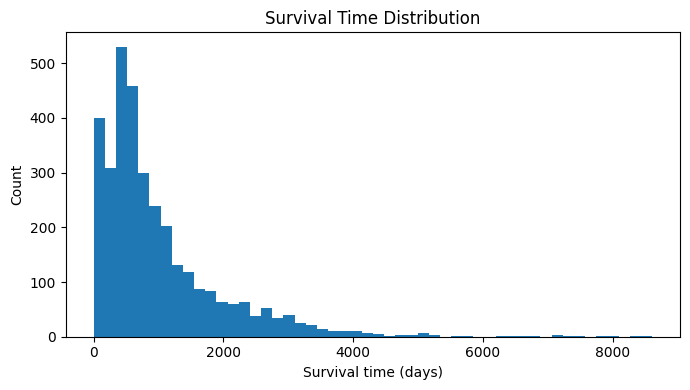


=== PER-COHORT SURVIVAL SUMMARY ===


,cohort,n_total,n_events,n_censored
1,BRCA,1093,151,942
5,UCEC,543,91,452
3,LGG,514,125,389
4,LUAD,509,183,326
0,BLCA,405,177,228
2,GBM,287,231,56



=== MISSINGNESS IN KEY CLINICAL COLUMNS ===
cohort         : missing 0 / 3385
gender         : missing 19 / 3385
race           : missing 19 / 3385
ethnicity      : missing 19 / 3385
vital_status   : missing 19 / 3385
survival_time  : missing 34 / 3385
event          : missing 34 / 3385

=== EXPRESSION QC ===
Total NaNs in expression: 0
Samples with NaNs: 0
Genes with NaNs  : 0

Expression summary:
 min: 0.0
 q25: 0.14552806317806244
 med: 1.0405044555664062
 q75: 1.6250139474868774
 max: 5.060554504394531


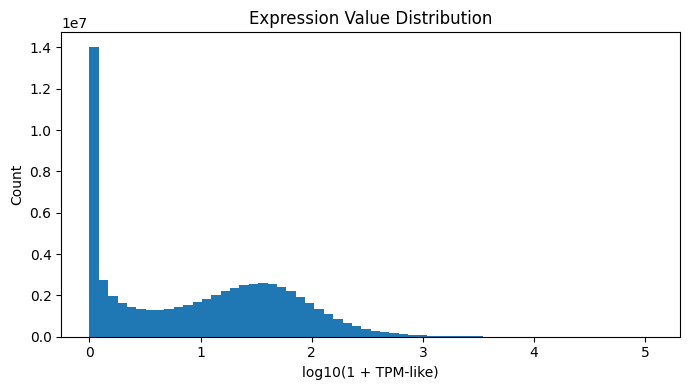


QC COMPLETE.


In [43]:
# ============================================
# FINAL QC FOR EXPRESSION + CLINICAL TABLES
# ============================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Paths ----------
PROJECT_ROOT  = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROCESSED_DIR = PROJECT_ROOT / "processed"

EXPR_FILE = PROCESSED_DIR / "tcga_tpm_like_log10_bulkrnabert_aligned.parquet"
CLIN_FILE = PROCESSED_DIR / "tcga_clinical_bulkrnabert_cohorts.parquet"

print("Expression file:", EXPR_FILE)
print("Clinical file  :", CLIN_FILE)

# ---------- Load ----------
expr = pd.read_parquet(EXPR_FILE)     # samples x genes
clinical = pd.read_parquet(CLIN_FILE) # sample_id as index expected

expr.index.name = "sample_id"
clinical.index.name = "sample_id"

print("\n=== BASIC SHAPES ===")
print("Expression matrix :", expr.shape)
print("Clinical table    :", clinical.shape)

# ============================================
# 1) SAMPLE MATCH CHECKS
# ============================================

expr_ids = expr.index
clin_ids = clinical.index

print("\n=== SAMPLE ID OVERLAP ===")
print("Expression sample IDs:", len(expr_ids))
print("Clinical sample IDs  :", len(clin_ids))

common_ids = expr_ids.intersection(clin_ids)
only_expr  = expr_ids.difference(clin_ids)
only_clin  = clin_ids.difference(expr_ids)

print("Common IDs:", len(common_ids))
print("Only in expression:", len(only_expr))
print("Only in clinical  :", len(only_clin))

if len(only_expr) > 0:
    print("Example only_expr:", list(only_expr[:5]))
if len(only_clin) > 0:
    print("Example only_clin:", list(only_clin[:5]))

print("\n=== DUPLICATE CHECK ===")
print("Expr duplicated:", expr_ids.duplicated().sum())
print("Clin duplicated:", clin_ids.duplicated().sum())

expr_qc = expr.loc[common_ids].sort_index()
clinical_qc = clinical.loc[common_ids].sort_index()

print("\nShapes after alignment:")
print("expr_qc    :", expr_qc.shape)
print("clinical_qc:", clinical_qc.shape)

# ============================================
# 2) COHORT DISTRIBUTION
# ============================================

print("\n=== COHORT DISTRIBUTION ===")
if "cohort" in clinical_qc.columns:
    print(clinical_qc["cohort"].value_counts())
else:
    print("WARN: no 'cohort' column found.")

# ============================================
# 3) SURVIVAL LABEL QC
# ============================================

print("\n=== SURVIVAL LABELS ===")

print("Non-null survival_time:", clinical_qc["survival_time"].notna().sum())
print("Non-null event        :", clinical_qc["event"].notna().sum())

surv_df = clinical_qc.dropna(subset=["survival_time", "event"])
print("Rows with valid survival:", surv_df.shape[0])

# Event distribution
print("\nEvent distribution:")
print(surv_df["event"].value_counts(dropna=False))

unique_events = np.sort(surv_df["event"].unique())
print("Unique event values:", unique_events)

if not set(unique_events).issubset({0, 1, 0.0, 1.0}):
    print("WARN: event has values outside {0,1}")

# Survival time stats
print("\nSurvival time stats:")
print(surv_df["survival_time"].describe())

neg_times = (surv_df["survival_time"] < 0).sum()
zero_times = (surv_df["survival_time"] == 0).sum()
print("Negative survival_time:", neg_times)
print("Zero survival_time    :", zero_times)

# Plot survival histogram
plt.figure(figsize=(7,4))
plt.hist(surv_df["survival_time"], bins=50)
plt.xlabel("Survival time (days)")
plt.ylabel("Count")
plt.title("Survival Time Distribution")
plt.tight_layout()
plt.show()

# ============================================
# 4) PER-COHORT SURVIVAL QC
# ============================================

print("\n=== PER-COHORT SURVIVAL SUMMARY ===")
cohort_stats = []

for coh in sorted(surv_df["cohort"].unique()):
    sub = surv_df[surv_df["cohort"] == coh]
    cohort_stats.append({
        "cohort": coh,
        "n_total": len(sub),
        "n_events": int((sub["event"] == 1).sum()),
        "n_censored": int((sub["event"] == 0).sum()),
    })

cohort_stats_df = pd.DataFrame(cohort_stats).sort_values("n_total", ascending=False)
display(cohort_stats_df)

tiny = cohort_stats_df[cohort_stats_df["n_events"] < 10]
if len(tiny) > 0:
    print("\n⚠️ Cohorts with < 10 death events (weak for survival modeling):")
    display(tiny)

# ============================================
# 5) CLINICAL MISSINGNESS
# ============================================

print("\n=== MISSINGNESS IN KEY CLINICAL COLUMNS ===")
key_cols = [
    "cohort", "gender", "race", "ethnicity",
    "vital_status", "survival_time", "event"
]

for col in key_cols:
    if col in clinical_qc.columns:
        missing = clinical_qc[col].isna().sum()
        print(f"{col:15s}: missing {missing} / {clinical_qc.shape[0]}")
    else:
        print(f"{col:15s}: NOT FOUND")

# ============================================
# 6) EXPRESSION QC
# ============================================

print("\n=== EXPRESSION QC ===")

# NaNs
nan_total = np.isnan(expr_qc.values).sum()
print("Total NaNs in expression:", nan_total)

nan_per_sample = np.isnan(expr_qc.values).sum(axis=1)
nan_per_gene   = np.isnan(expr_qc.values).sum(axis=0)
print("Samples with NaNs:", (nan_per_sample > 0).sum())
print("Genes with NaNs  :", (nan_per_gene > 0).sum())

# Expression distribution
flat = expr_qc.values.flatten()
flat = flat[np.isfinite(flat)]

print("\nExpression summary:")
print(" min:", float(flat.min()))
print(" q25:", float(np.quantile(flat, 0.25)))
print(" med:", float(np.median(flat)))
print(" q75:", float(np.quantile(flat, 0.75)))
print(" max:", float(flat.max()))

plt.figure(figsize=(7,4))
plt.hist(flat, bins=60)
plt.xlabel("log10(1 + TPM-like)")
plt.ylabel("Count")
plt.title("Expression Value Distribution")
plt.tight_layout()
plt.show()

print("\nQC COMPLETE.")


In [42]:
# 13) Align clinical table to expression samples and save to PROCESSED_DIR

# Load your main log-TPM aligned matrix (samples x genes)
EXPR_ALIGNED_PATH = PROCESSED_DIR / "tcga_tpm_like_log10_bulkrnabert_aligned.parquet"
expr_aligned = pd.read_parquet(EXPR_ALIGNED_PATH)
print("Expression aligned shape:", expr_aligned.shape)

# Align by sample_id
clinical_df = clinical_df.set_index("sample_id")

common_samples = expr_aligned.index.intersection(clinical_df.index)
print("Samples in expression:", expr_aligned.shape[0])
print("Samples in clinical  :", clinical_df.shape[0])
print("Common samples       :", len(common_samples))

clinical_aligned = clinical_df.loc[common_samples].copy()

# Basic diagnostics
print("\nNon-null survival_time:", clinical_aligned["survival_time"].notna().sum())
print("Non-null event        :", clinical_aligned["event"].notna().sum())
print("\nCohort counts:")
print(clinical_aligned["cohort"].value_counts())

# Save cleaned, aligned clinical table
CLIN_OUT = PROCESSED_DIR / "tcga_clinical_bulkrnabert_cohorts.parquet"
clinical_aligned.to_parquet(CLIN_OUT)

print("\nSaved aligned clinical to:", CLIN_OUT)


Expression aligned shape: (3385, 19062)
Samples in expression: 3385
Samples in clinical  : 3788
Common samples       : 3385

Non-null survival_time: 3351
Non-null event        : 3351

Cohort counts:
cohort
BRCA    1095
UCEC     557
LUAD     518
LGG      516
BLCA     406
GBM      293
Name: count, dtype: int64

Saved aligned clinical to: /content/drive/MyDrive/bdh_challenge_2025_data/processed/tcga_clinical_bulkrnabert_cohorts.parquet
